## Configurations

In [734]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from scipy.optimize import curve_fit
import pandas as pd

def normalize(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))
def decay1(t,A,tau,y0):
    return A*np.exp(-t/tau)+y0
def decay2(t,A1,A2,tau1,tau2,y0):
    return A1*np.exp(-t/tau1)+A2*np.exp(-t/tau2)+y0
def curve_fit_new(f, xdata, ydata,unit_time=50):
    popt, pcov = curve_fit(f, xdata/unit_time, ydata,bounds=(0,np.inf))#,maxfev=100000)
    perr = np.sqrt(np.diag(pcov))
    if f == decay2:
        popt_new = np.concatenate([popt[:2],popt[2:4]*unit_time,popt[4:]])
        perr_new = np.concatenate([perr[:2],perr[2:4]*unit_time,perr[4:]])
    elif f == decay1:
        popt_new = np.concatenate([popt[:1],popt[1:2]*unit_time,popt[2:]])
        perr_new = np.concatenate([perr[:1],perr[1:2]*unit_time,perr[2:]])
    return popt_new,perr_new
def plotBigGraphs(which,normalized_list,minor_shift,num_points = 1400,unit_time = 50,cutoff_raw = 70,offsetdiv = 10):
    if which == 'G':
        minor_shift = [0,0,0,1,0,1,0,0,0,3]
        normalized_list = normalized_Glist
        bigFigurePath = savePath+'/G_big.png'
        smallFigurePath = savePath+'/G_small.png'
    elif which == 'B':
        minor_shift = [0,0,0,0,0,1,0,0,0,1]
        normalized_list = normalized_Blist
        bigFigurePath = savePath+'/B_big.png'
        smallFigurePath = savePath+'/B_small.png'
    
    fast_list = []
    slow_list = []
    plt.ioff()
    fig,axs = plt.subplots(3,4,figsize=(15,10))
    for ind,normalized in enumerate(normalized_list):
        cutoff = cutoff_raw-minor_shift[ind]
        xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
        ax = axs[ind//4,ind%4]
        popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(normalized)],normalized[cutoff:])
        fast_list.append(np.min(popt_new[2:4]))
        slow_list.append(np.max(popt_new[2:4]))
        ax.plot(xlist[cutoff:len(normalized)]/1e3,decay2(xlist[cutoff:len(normalized)],*popt_new)-popt_new[-1]/offsetdiv,color='red',linewidth=1.5)
        ax.plot(xlist[:len(normalized)]/1e3,normalized[:]-popt_new[-1]/offsetdiv,'-',linewidth=1,color='black',zorder=-9)
        ax.set_yscale('log')
        ax.set_xlim(xlist[0]/1e3,65)
        ax.set_ylim(7e-2,1.2)
        ax.set_xlabel('Time (µs)')
        ax.set_ylabel('iMIM-Im (a.u.)')
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(1.5)
#         ax.xaxis.set_tick_params(width=2,length=5)
#         ax.yaxis.set_tick_params(width=2,length=5)
#         ax.xaxis.set_tick_params(width=2,length=5)
#         ax.yaxis.set_tick_params(which='minor',width=2)
    #     ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
        ax.set_xticks(np.arange(0,70,10))
    plt.tight_layout(pad=2)
    plt.savefig(bigFigurePath)
    
    return fast_list,slow_list

def plotPos(pos_list,decay=1,log=False,xlim=None,ylim=None,cutoff_raw = 81,offsetdiv=10,expand=1.,minor_shift = [0,0,0,0,0,0,0,0,0,0,0,0,0,],smallWindows=0,pad=1,height=3):
    num_points = 1400
    unit_time = 50
    fast_list = []
    slow_list = []
    fast_A_list = []
    slow_A_list = []
    one_list = []
    one_A_list = []
    
    fig,axs = plt.subplots(1,len(pos_list),figsize=(4*len(pos_list),height))
    for ind,etl in enumerate(pos_list):
        cutoff = cutoff_raw-minor_shift[ind]
        xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
        ax = axs[ind]
        ydata = normalize(etl+1.75*ind)*expand

        if decay == 2:
            popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(ydata)],ydata[cutoff:])
#             print(popt_new)
            fast_ind = np.argmin(popt_new[2:4])
            slow_ind = np.argmax(popt_new[2:4])
            fast_list.append(popt_new[fast_ind+2])
            slow_list.append(popt_new[slow_ind+2])
            fast_A_list.append(popt_new[fast_ind]) 
            slow_A_list.append(popt_new[slow_ind]) 
            ax.plot(xlist[cutoff:len(ydata)]/1e3,decay2(xlist[cutoff:len(ydata)],*popt_new)-popt_new[-1]/offsetdiv,color='red',linewidth=2)
        elif decay == 1:
            popt_new,perr_new = curve_fit_new(decay1,xlist[cutoff:len(ydata)],ydata[cutoff:])
#             print(popt_new)
            one_ind = 1
            one_list.append(popt_new[one_ind])
            one_A_list.append(popt_new[0]) 
            ax.plot(xlist[cutoff:len(ydata)]/1e3,decay1(xlist[cutoff:len(ydata)],*popt_new)-popt_new[-1]/offsetdiv,color='red',linewidth=2)
        ax.plot(xlist[:len(etl)]/1e3,ydata-popt_new[-1]/offsetdiv,color='black',zorder=-9)
        if smallWindows == 0:
            if ind == 0:
                    ax.set_ylabel('iMIM-Im (a.u.)')
            else:
                    ax.get_yaxis().set_ticks([])
            ax.set_xlabel('Time (µs)')
        else:
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(15)
        if log == True:
            ax.set_yscale('log')
        if ylim is not None:
            ax.set_ylim(ylim[0],ylim[1])
        if xlim is not None:
            ax.set_xlim(xlim[0],xlim[1])
        else:
            ax.set_xlim(xlist[0]/1e3,65)
    plt.tight_layout(pad=pad)
    return one_list,fast_list,slow_list

Using matplotlib backend: Qt5Agg


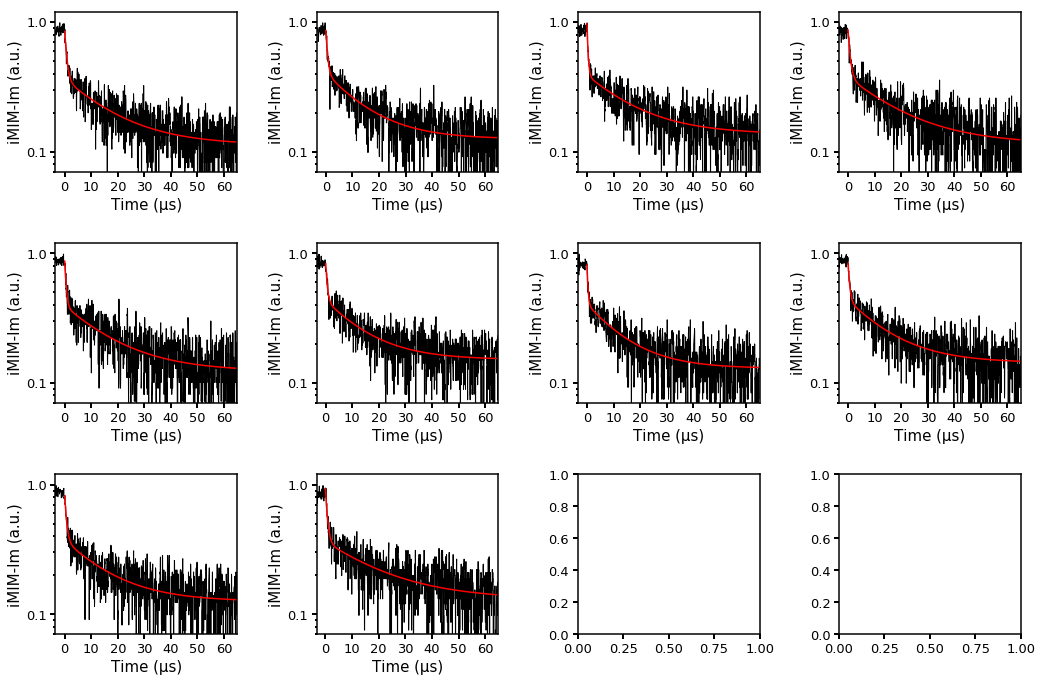

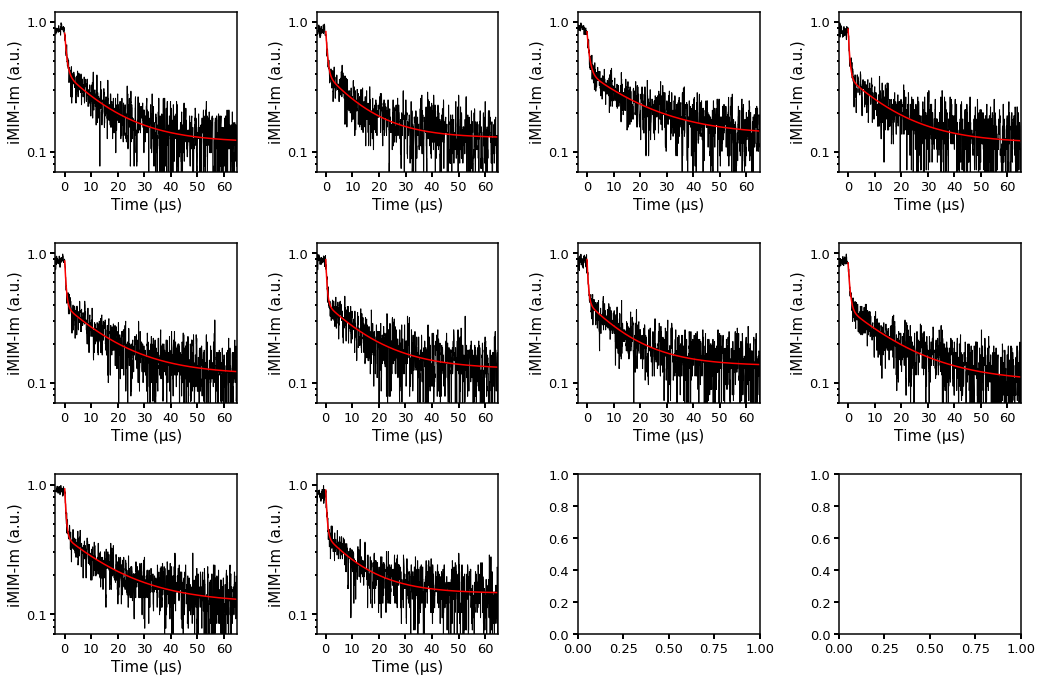

In [221]:
%matplotlib auto



SMALL_SIZE = 8
MEDIUM_SIZE = 13
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major',size=5,width=2)
plt.rc('ytick.major',size=5,width=2)
plt.rc('xtick.minor',size=2,width=2)
plt.rc('ytick.minor',size=2,width=2)




savePath = "../Perovskite_KaiZhu(2nd_floor)/Sample_201911/1/processFiles/"
B_root = "../Perovskite_KaiZhu(2nd_floor)/Sample_201911/1/20200129_446nm_20_points/Data/"
G_root = B_root
B_files = ["2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B1_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B2_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B3_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B4_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B5_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B6_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B7_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B8_transposed.csv",
          "2020-01-30_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B9_transposed.csv",
          "2020-01-30_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_B10_transposed.csv"]
G_files = ["2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G1_again_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G2_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G3_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G4_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G5_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G6_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G7_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G8_transposed.csv",
          "2020-01-29_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G9_transposed.csv",
          "2020-01-30_7kHz_result_0.0028_446nm_KaiZhu_Provskite1_Im_5usx14ns_average30times_G10_transposed.csv"]

data_Blist = [pd.read_csv(B_root+file,header=None)[0].values for file in B_files]
data_Glist = [pd.read_csv(G_root+file,header=None)[0].values for file in G_files]
normalized_Blist = [normalize(item) for item in data_Blist]
normalized_Glist = [normalize(item) for item in data_Glist]

#minor_shift = [0,0,0,0,0,1,0,0,0,1]
minor_shift = [0,0,0,1,0,1,0,0,0,3]

fast_Glist,slow_Glist = plotBigGraphs('G',normalized_Glist,minor_shift)
fast_Blist,slow_Blist = plotBigGraphs('B',normalized_Blist,minor_shift)


t1 Grain: 0.6150933481490066
t1 Boundary: 0.6116279562278379
t2 Grain: 16.416291187650458
t2 Boundary: 16.206966275614437


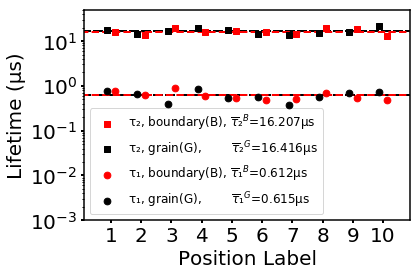

In [222]:
import numpy as np
import matplotlib.pyplot as plt
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major',size=3,width=2)
plt.rc('ytick.major',size=3,width=2)
plt.rc('xtick.minor',size=2,width=1)
plt.rc('ytick.minor',size=2,width=1)

# t1_G_list = np.asarray([866.66511,773.89004,556.51447,882.48158,644.69493,645.01299,438.60335,598.80665,819.65826,730.30574])/1000
# t1_B_list = np.asarray([842.22812,743.47775,997.40317,680.57775,604.59577,513.29562,647.65729,780.53478,645.0389,557.08436])/1000
# t2_G_list = np.asarray([17813.18258,14568.61247,17769.69621,19446.6767,17903.719,14174.62262,13554.3532,14978.64816,16057.04112,21151.842])/1000
# t2_B_list = np.asarray([15837.84388,13665.93613,19886.85435,16813.93666,17317.41025,15604.54352,14858.42028,19656.09712,18938.22791,13190.91359])/1000
t1_G_list = np.asarray(fast_Glist)/1000
t1_B_list = np.asarray(fast_Blist)/1000
t2_G_list = np.asarray(slow_Glist)/1000
t2_B_list = np.asarray(slow_Blist)/1000

t1_G_mean = np.mean(t1_G_list)
t1_B_mean = np.mean(t1_B_list)
t2_G_mean = np.mean(t2_G_list)
t2_B_mean = np.mean(t2_B_list)
print("t1 Grain:",t1_G_mean)
print("t1 Boundary:",t1_B_mean)
print("t2 Grain:",t2_G_mean)
print("t2 Boundary:",t2_B_mean)
# t1_G_std = np.std(t1_G_list)
# t1_B_std = np.std(t1_B_list)
# t2_G_std = np.std(t2_G_list)
# t2_B_std = np.std(t2_B_list)
t1_G_std = np.array([70.35679,74.42368,48.80223,84.13497,69.26422,81.72991,48.96266,63.18758,83.93289,70.52462])
t2_G_std = np.array([1369.13997,975.75943,1350.35693,1764.94823,1484.0215,918.88845,832.21779,953.43973,1345.50963,2220.45955])
t1_B_std = np.array([77.83112,68.50899,88.94773,61.86313,48.55473,49.44132,67.70574,63.05848,46.50974,52.24646])
t2_B_std = np.array([980.1255,860.95999,1537.57537,1340.98951,1057.86242,997.69036,998.15669,1393.47919,1194.50137,857.29649])
# t1_G_errorbar = [[t1_G_mean-t1_G_std/2,t1_G_mean+t1_G_std/2] for item in t1_G_list]
# t2_G_errorbar = [[t2_G_mean-t2_G_std/2,t2_G_mean+t2_G_std/2] for item in t2_G_list]
# t1_B_errorbar = [[t1_B_mean-t1_B_std/2,t1_B_mean+t1_B_std/2] for item in t1_B_list]
# t2_B_errorbar = [[t2_B_mean-t2_B_std/2,t2_B_mean+t2_B_std/2] for item in t2_B_list]
t1_G_errorbar = [[item-t1_G_std[ind],item+t1_G_std[ind]] for ind,item in enumerate(t1_G_list)]
t2_G_errorbar = [[item-t2_G_std[ind],item+t2_G_std[ind]] for ind,item in enumerate(t2_G_list)]
t1_B_errorbar = [[item-t1_B_std[ind],item+t1_B_std[ind]] for ind,item in enumerate(t1_B_list)]
t2_B_errorbar = [[item-t2_B_std[ind],item+t2_B_std[ind]] for ind,item in enumerate(t2_B_list)]

marker_size = 45

pos_list_G = np.array([1,2,3,4,5,6,7,8,9,10])-0.125
pos_list_B = np.array([1,2,3,4,5,6,7,8,9,10])+0.125
plt.figure()
plt.scatter(pos_list_G,t1_G_list,color='black',s=marker_size,label="τ₁, grain(G),        $\overline{τ}$₁$^G$="+"{:.3f}µs".format(t1_G_mean),zorder=100)
plt.plot([0,11],[t1_G_mean,t1_G_mean],color = 'black',linestyle='dashed',dashes = (5,1),linewidth=2)
# for ind,item in enumerate(t1_G_errorbar):
#      plt.errorbar(pos_list_G[ind],t1_G_errorbar[ind],color = 'black',fmt='-_',capsize=1,zorder=0,linewidth=0.5)
plt.scatter(pos_list_B,t1_B_list,color='red',s=marker_size,label="τ₁, boundary(B), $\overline{τ}$₁$^B$="+"{:.3f}µs".format(t1_B_mean),zorder=100)        
plt.plot([0,11],[t1_B_mean,t1_B_mean],color = 'red',linestyle='dashed',linewidth=2)
# for ind,item in enumerate(t1_B_errorbar):
#      plt.errorbar(pos_list_B[ind],t1_B_errorbar[ind],color = 'red',fmt='-_',capsize=1,zorder=0,linewidth=0.5)
plt.yscale('log')
# plt.plot([1,10])
# plt.ylim(10,5e4)

# plt.figure()
plt.scatter(pos_list_G,t2_G_list,color='black',marker = 's',s=marker_size,label="τ₂, grain(G),        $\overline{τ}$₂$^G$="+"{:.3f}µs".format(t2_G_mean),zorder=100)
plt.plot([0,11],[t2_G_mean,t2_G_mean],color = 'black',linestyle='dashed',dashes = (5,1),linewidth=2)
# for ind,item in enumerate(t2_G_errorbar):
#      plt.errorbar(pos_list_G[ind],t2_G_errorbar[ind],color = 'black',fmt='-_',capsize=1,zorder=0,linewidth=0.5)
plt.scatter(pos_list_B,t2_B_list,color='red',marker='s',s=marker_size,label="τ₂, boundary(B), $\overline{τ}$₂$^B$="+"{:.3f}µs".format(t2_B_mean),zorder=100)
plt.plot([0,11],[t2_B_mean,t2_B_mean],color = 'red',linestyle='dashed',linewidth=2)
# for ind,item in enumerate(t2_B_errorbar):
#      plt.errorbar(pos_list_B[ind],t2_B_errorbar[ind],color = 'red',fmt='-_',capsize=1,zorder=0,linewidth=0.5)

# plt.yscale('log')
plt.ylim(1e-3,5e1)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], )# loc='upper left')

# plt.legend()
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlim(0.1,10.9) 
plt.xlabel("Position Label")
plt.ylabel("Lifetime (µs)")
plt.tight_layout()

plt.savefig(savePath+'/20points_446nm.png')

Text(0.5,1,'HTL (electrons)')

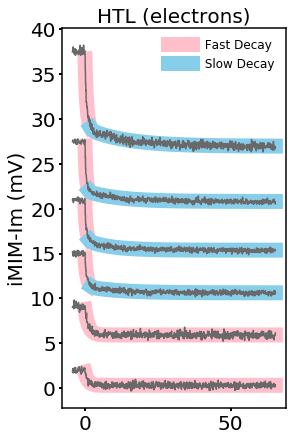

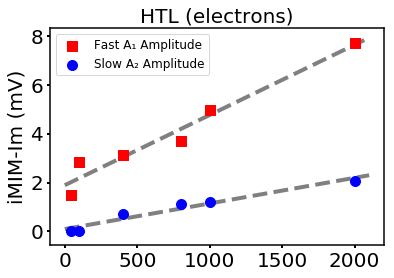

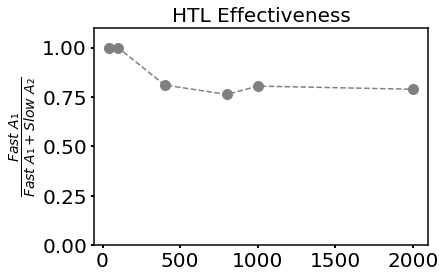

C:\Users\Zhaodong Chu\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


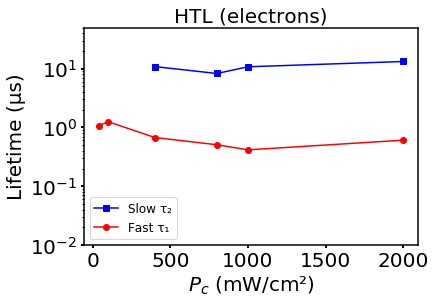

In [782]:
%matplotlib inline
HTL_root = "../Perovskite/HTL_ETL2/HTL_gloveBox/Data/"

HTL_intensity_files = ["2020-06-25_7kHz_result_0.0010_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                       "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-25_7kHz_result_0.0098_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "tmp2020-06-27_7kHz_result_0.0155_446nm_KaiZhu_Provskite_HTLGloveBoxRound2_Im_5usx14ns_average30times_randPos_transposed.csv",
                       "tmp2020-06-27_7kHz_result_0.0216_446nm_KaiZhu_Provskite_HTLGloveBoxRound2_Im_5usx14ns_average30times_randPos_transposed.csv",
                       "2020-06-25_7kHz_result_0.0155_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv"]
HTL_intensity_list = [-pd.read_csv(HTL_root+file,header=None)[0].values for file in HTL_intensity_files]
plt.figure(figsize=(4,7))
plt.title("HTL (electrons)")
plt.ylabel('iMIM-Im (mV)')
minor_shift=[0,0,0,0,0,0,]
fast_list = []
slow_list = []
fast_A_list = []
slow_A_list = []
for ind,htl in enumerate(HTL_intensity_list):
#     plt.plot(htl+1.75*ind)
    cutoff = cutoff_raw-minor_shift[ind]
    num_points = 1400
    unit_time = 50
    cutoff_raw = 86
    xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
    ydata = htl+5*ind
    plt.plot(xlist[:len(ydata)]/1e3,ydata,color = 'dimgray')
    if ind >= 2:
        popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(ydata)],ydata[cutoff:])
        fast_ind = np.argmin(popt_new[2:4])
        slow_ind = np.argmax(popt_new[2:4])
        fast_list.append(popt_new[fast_ind+2])
        slow_list.append(popt_new[slow_ind+2])
        fast_A_list.append(popt_new[fast_ind]) 
        slow_A_list.append(popt_new[slow_ind]) 
        fit_data = decay2(xlist[cutoff:len(ydata)],*popt_new)
        deltay = np.ptp(fit_data)
        prop = popt_new[fast_ind]/(popt_new[fast_ind]+popt_new[slow_ind])
        threshy = np.max(fit_data)-prop*deltay
        fast_fit = []
        slow_fit = []
        for item in fit_data:
            if item>=threshy:
                fast_fit.append(item)
            else:
                slow_fit.append(item)
        if ind == 2:
            plt.plot(xlist[cutoff:len(fast_fit)+cutoff]/1e3,fast_fit,color='pink',linewidth=15,zorder=-9,label=' Fast Decay')
            plt.plot(xlist[cutoff+len(fast_fit):cutoff+len(fast_fit)+len(slow_fit)]/1e3,slow_fit,color='skyblue',linewidth=15,zorder=-8,label=' Slow Decay')
        else:    
            plt.plot(xlist[cutoff:len(fast_fit)+cutoff]/1e3,fast_fit,color='pink',linewidth=15,zorder=-9)
            plt.plot(xlist[cutoff+len(fast_fit):cutoff+len(fast_fit)+len(slow_fit)]/1e3,slow_fit,color='skyblue',linewidth=15,zorder=-8)
    else:
        popt_new,perr_new = curve_fit_new(decay1,xlist[cutoff:len(ydata)],ydata[cutoff:])
        fast_list.append(popt_new[1])
        fast_A_list.append(popt_new[0]) 
        slow_list.append(np.nan)
        slow_A_list.append(0)
        plt.plot(xlist[cutoff:len(ydata)]/1e3,decay1(xlist[cutoff:len(ydata)],*popt_new),color='pink',linewidth=15,zorder=-8)
plt.legend(edgecolor='None')
        
plt.figure()        
intensity_list = [40,100,400,800,1000,2000]
plt.scatter(intensity_list,fast_A_list,label='Fast A₁ Amplitude',color = 'red',s=100,zorder=10,marker='s')
m,b = np.polyfit(intensity_list, fast_A_list, 1)
plt.plot([0,2100],[m*0+b,m*2100+b],color="gray",linestyle="dashed",linewidth=4)

plt.scatter(intensity_list,slow_A_list,label='Slow A₂ Amplitude',color = 'blue',s=100,zorder=10)
m,b = np.polyfit(intensity_list, slow_A_list, 1)
plt.plot([0,2100],[m*0+b,m*2100+b],color="gray",linestyle="dashed",linewidth=4)


plt.legend()
plt.title('HTL (electrons)')
plt.ylabel('iMIM-Im (mV)')

plt.figure()
plt.plot(intensity_list,[item2/(item1+item2) for item1,item2 in zip(slow_A_list,fast_A_list)],'.--',markersize=20,color='gray')
plt.ylim(0,1.1)
plt.title('HTL Effectiveness')
plt.ylabel('$\\frac{Fast\ A₁}{Fast\ A₁+Slow\ A₂}$')

plt.figure()
ETL_t_list = slow_list
HTL_t_list = fast_list
ETL_mean = np.nanmean(ETL_t_list)/1e3
HTL_mean = np.nanmean(HTL_t_list)/1e3
plt.plot(intensity_list,np.asarray(ETL_t_list)/1e3,color='blue',marker='s',label='Slow τ₂')#label='$\overline{τ}_{hole}$='+'{:.2f}'.format(ETL_mean)+'µs')
plt.plot(intensity_list,np.asarray(HTL_t_list)/1e3,color='red',marker='o',label='Fast τ₁')#label='$\overline{τ}_{electron}$='+'{:.2f}'.format(HTL_mean)+'µs')
plt.yscale('log')
plt.ylim(1e-2,5e1)
plt.legend()
plt.ylabel('Lifetime (µs)')
plt.xlabel("$P_c$ (mW/cm²)")
plt.title('HTL (electrons)')

In [695]:
np.asarray(ETL_t_list)/1e3

array([        nan,         nan, 10.83815761,  8.27150015, 10.75927007,
       13.23358071])

In [ ]:
fast_list

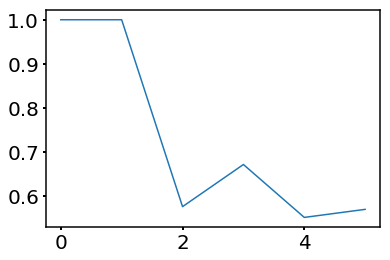

In [594]:
fast_list

[997.5578526119708,
 1249.4370627350222,
 673.7815973554123,
 507.3221437454341,
 415.3753206162692,
 607.193024865696]

0.42366002598794966
0.32811183262082994
0.4480722613542264
0.4298126258311066


Text(0.5,1,'ETL (holes)')

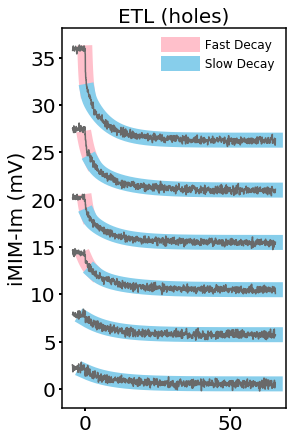

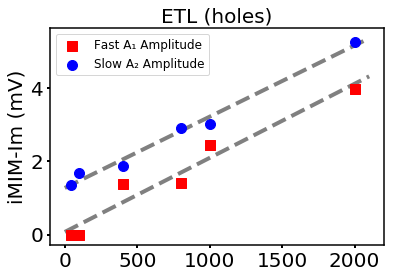

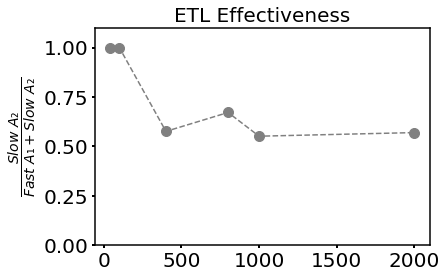

C:\Users\Zhaodong Chu\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


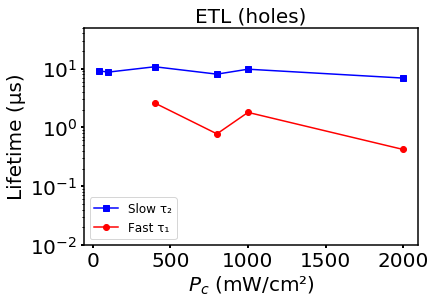

In [783]:
%matplotlib inline
ETL_root = "../Perovskite/HTL_ETL2/ETL_TiO2_firstBatch/Data/"

ETL_intensity_files = [#"2020-06-26_7kHz_result_0.0004_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0010_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      #"2020-06-26_7kHz_result_0.0030_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0050_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0084_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0098_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      ##"2020-06-26_7kHz_result_0.0155_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      "2020-06-26_7kHz_result_0.0216_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                      #"tmp2020-06-27_7kHz_result_0.0261_446nm_KaiZhu_Provskite_ETLTiO2FirstBatchVacuumChamber_Im_5usx14ns_average30times_randPos_transposed.csv",
                      #"tmp2020-06-27_7kHz_result_0.0270_446nm_KaiZhu_Provskite_ETLTiO2FirstBatchVacuumChamber_Im_5usx14ns_average30times_randPos_transposed.csv"
                      ]
ETL_intensity_list = [-pd.read_csv(ETL_root+file,header=None)[0].values for file in ETL_intensity_files]
plt.figure(figsize=(4,7))
plt.title("ETL (holes)")
plt.ylabel('iMIM-Im (mV)')

minor_shift=[0,0,0,0,0,0,0,]
fast_list = []
slow_list = []
fast_A_list = []
slow_A_list = []
for ind,etl in enumerate(ETL_intensity_list):
    cutoff = cutoff_raw-minor_shift[ind]
    num_points = 1400
    unit_time = 50
    cutoff_raw = 85
    xlist = np.arange(0,num_points*unit_time,unit_time) - cutoff*unit_time
    ydata = etl+5*ind
    plt.plot(xlist[:len(ydata)]/1e3,ydata,color='dimgray')
    if ind >=2:
        popt_new,perr_new = curve_fit_new(decay2,xlist[cutoff:len(ydata)],ydata[cutoff:])
        fast_ind = np.argmin(popt_new[2:4])
        slow_ind = np.argmax(popt_new[2:4])
        fast_list.append(popt_new[fast_ind+2])
        slow_list.append(popt_new[slow_ind+2])
        fast_A_list.append(popt_new[fast_ind]) 
        slow_A_list.append(popt_new[slow_ind]) 
        fit_data = decay2(xlist[cutoff:len(ydata)],*popt_new)
        deltay = np.ptp(fit_data)
        prop = popt_new[fast_ind]/(popt_new[fast_ind]+popt_new[slow_ind])
        threshy = np.max(fit_data)-prop*deltay
        print(prop)
        fast_fit = []
        slow_fit = []
        for item in fit_data:
            if item>=threshy:
                fast_fit.append(item)
            else:
                slow_fit.append(item)
        if ind == 2:
            plt.plot(xlist[cutoff:len(fast_fit)+cutoff]/1e3,fast_fit,color='pink',linewidth=15,zorder=-9,label=' Fast Decay')
            plt.plot(xlist[cutoff+len(fast_fit):cutoff+len(fast_fit)+len(slow_fit)]/1e3,slow_fit,color='skyblue',linewidth=15,zorder=-8,label=' Slow Decay')
        else:    
            plt.plot(xlist[cutoff:len(fast_fit)+cutoff]/1e3,fast_fit,color='pink',linewidth=15,zorder=-9)
            plt.plot(xlist[cutoff+len(fast_fit):cutoff+len(fast_fit)+len(slow_fit)]/1e3,slow_fit,color='skyblue',linewidth=15,zorder=-8)
    else:
        popt_new,perr_new = curve_fit_new(decay1,xlist[cutoff:len(ydata)],ydata[cutoff:])
        slow_list.append(popt_new[1])
        slow_A_list.append(popt_new[0]) 
        fast_list.append(np.nan)
        fast_A_list.append(0)
        plt.plot(xlist[cutoff:len(ydata)]/1e3,decay1(xlist[cutoff:len(ydata)],*popt_new),color='skyblue',linewidth=15,zorder=-8)
plt.legend(edgecolor='None')
    
#     plt.plot(xlist[cutoff:len(ydata)]/1e3,decay2(xlist[cutoff:len(ydata)],*popt_new),color='red',linewidth=2)
#     plt.plot(xlist[cutoff:len(ydata)]/1e3,decay1(xlist[cutoff:len(ydata)],popt_new[slow_ind],popt_new[slow_ind+2],popt_new[-1])-popt_new[-1]/offsetdiv,color='red',linewidth=2)
#     plt.plot(xlist[cutoff:len(ydata)]/1e3,decay1(xlist[cutoff:len(ydata)],popt_new[fast_ind],popt_new[fast_ind+2],popt_new[-1])-popt_new[-1]/offsetdiv,color='red',linewidth=2)
plt.figure()        
intensity_list = [40,100,400,800,1000,2000]
plt.scatter(intensity_list,fast_A_list,label='Fast A₁ Amplitude',color = 'red',s=100,zorder=10,marker='s')
m,b = np.polyfit(intensity_list, fast_A_list, 1)
plt.plot([0,2100],[m*0+b,m*2100+b],color="gray",linestyle="dashed",linewidth=4)

plt.scatter(intensity_list,slow_A_list,label='Slow A₂ Amplitude',color = 'blue',s=100,zorder=10)
m,b = np.polyfit(intensity_list, slow_A_list, 1)
plt.plot([0,2100],[m*0+b,m*2100+b],color="gray",linestyle="dashed",linewidth=4)


plt.legend()
plt.title('ETL (holes)')
plt.ylabel('iMIM-Im (mV)')

plt.figure()
plt.plot(intensity_list,[item1/(item1+item2) for item1,item2 in zip(slow_A_list,fast_A_list)],'.--',markersize=20,color='gray')
plt.ylim(0,1.1)
plt.title('ETL Effectiveness')
plt.ylabel('$\\frac{Slow\ A₂}{Fast\ A₁+Slow\ A₂}$')

plt.figure()
ETL_t_list = slow_list
HTL_t_list = fast_list
ETL_mean = np.nanmean(ETL_t_list)/1e3
HTL_mean = np.nanmean(HTL_t_list)/1e3
plt.plot(intensity_list,np.asarray(ETL_t_list)/1e3,color='blue',marker='s',label='Slow τ₂')#label='$\overline{τ}_{hole}$='+'{:.2f}'.format(ETL_mean)+'µs')
plt.plot(intensity_list,np.asarray(HTL_t_list)/1e3,color='red',marker='o',label='Fast τ₁')#label='$\overline{τ}_{electron}$='+'{:.2f}'.format(HTL_mean)+'µs')
plt.yscale('log')
plt.ylim(1e-2,5e1)
plt.legend()
plt.ylabel('Lifetime (µs)')
plt.xlabel("$P_c$ (mW/cm²)")
plt.title('ETL (holes)')

In [615]:
0.35/(0.55+0.35)

0.38888888888888884

In [463]:
[item1/(item2+item1) for item1,item2 in zip(fast_A_list,slow_A_list)]
# fast_list

[0.6580231352044766,
 0.2986255789091342,
 0.37236063280396664,
 0.36082558232878265,
 0.40905935082647227,
 0.484957019114694]

([1229.199479116272,
  971.6297274704463,
  834.8309452178518,
  1124.4991620086132,
  900.8267206067198],
 [],
 [])

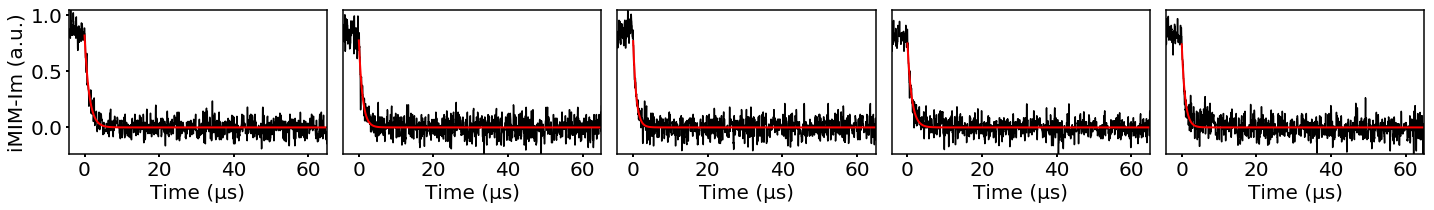

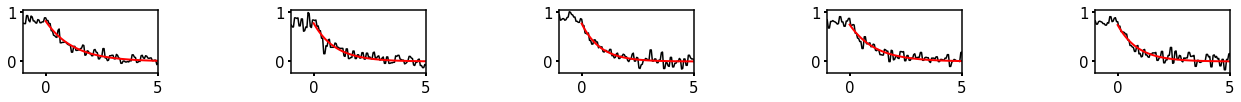

In [788]:
%matplotlib inline
HTL_root1 = "../Perovskite/HTL_ETL2/HTL_gloveBox/Data/"
HTL_root2 = "../Perovskite/HTL_ETL2/HTL_measuredDiffusion/Data/"

HTL_pos_files1 = ["2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                ##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos2_transposed.csv",
                "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos3_transposed.csv",
                "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos4_transposed.csv",
                ##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLGloveBox_Im_5usx14ns_average30times_randPos5_transposed.csv"
                ]
HTL_pos_files2 = [##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos_transposed.csv",
                  ##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos2_transposed.csv",
                  ##"2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos3_transposed.csv",
                  "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos4_transposed.csv",
                  "2020-06-25_7kHz_result_0.0018_446nm_KaiZhu_Provskite_HTLDiffusion_Im_5usx14ns_average30times_randPos5_transposed.csv",
                 ]

HTL_pos_list = [-pd.read_csv(HTL_root1+file,header=None)[0].values for file in HTL_pos_files1]+\
                [-pd.read_csv(HTL_root2+file,header=None)[0].values for file in HTL_pos_files2]
# plt.figure(figsize=(5,5))
# plt.title("random positions for HTL")
# for ind,htl in enumerate(HTL_pos_list):
#     plt.plot(htl+1.75*ind)
    
HTL_t_list,_,_ = plotPos(HTL_pos_list,decay=1,cutoff_raw=85,log=False,ylim=(-0.24,1.05),offsetdiv=1,expand=1/0.8)
plotPos(HTL_pos_list,decay=1,cutoff_raw=85,log=False,xlim=(-1,5),ylim=(-0.24,1.05),offsetdiv=1,expand=1/0.8,smallWindows=1,pad=10,height=4)

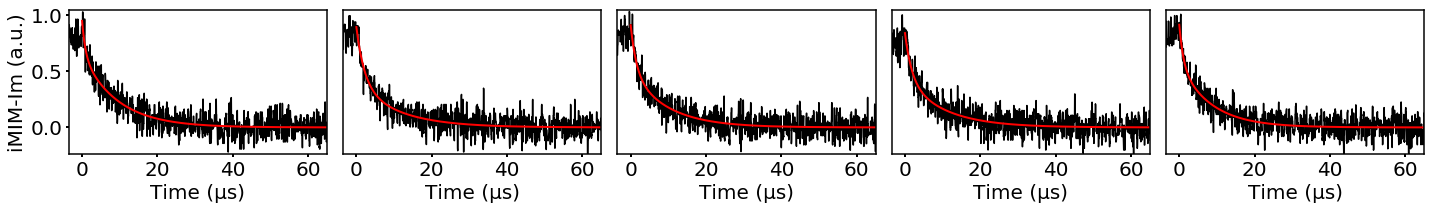

In [789]:
%matplotlib inline
ETL_root1 = "../Perovskite/HTL_ETL2/ETL_TiO2_firstBatch/Data/"
ETL_root2 = "../Perovskite/HTL_ETL2/ETL_TiO2_firstBatch_GloveBox/Data/"


ETL_pos_files1 = ["2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos_transposed.csv",
                  "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos2_transposed.csv",
                  "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos3_transposed.csv",
                  "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos4_transposed.csv",
                  "2020-06-26_7kHz_result_0.0018_446nm_KaiZhu_Provskite_TiO2ETL_Im_5usx14ns_average30times_randPos5_transposed.csv"
                 ]

ETL_pos_files2 = [#"2020-06-27_7kHz_result_0.0018_446nm_KaiZhu_Provskite_ETLTiO2FirstBatchGloveBox_Im_5usx14ns_average30times_randPos_transposed.csv",
                  #"2020-06-27_7kHz_result_0.0018_446nm_KaiZhu_Provskite_ETLTiO2FirstBatchGloveBox_Im_5usx14ns_average30times_randPos2_transposed.csv",
                 ]




ETL_pos_list = [-pd.read_csv(ETL_root1+file,header=None)[0].values for file in ETL_pos_files1]+\
                [-pd.read_csv(ETL_root2+file,header=None)[0].values for file in ETL_pos_files2]
# plt.figure(figsize=(5,5))
# plt.title("random positions of ETL (holes)")


# ETL_t_list = plotPos(ETL_pos_list,decay=1,cutoff_raw=75,log=False,ylim=(-0.24,1.05),offsetdiv=1,expand=1/0.8)

_,_,ETL_t_list = plotPos(ETL_pos_list,decay=2,cutoff_raw=71,log=False,ylim=(-0.24,1.05),offsetdiv=1,expand=1/0.8)
# plt.xlim(-5,10)
# np.mean(ETL_t_list)


In [748]:
ETL_t_list

[9256.382295278898,
 8615.712526543719,
 9261.765595369183,
 9281.221988874751,
 8392.486495634977]

Text(0.5,0,'Sampling points')

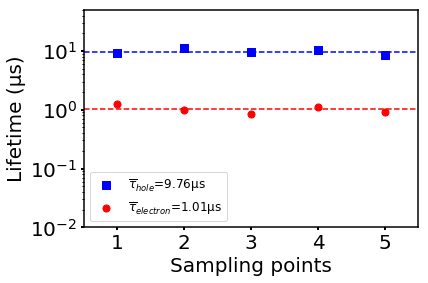

In [793]:
ETL_mean = np.mean(ETL_t_list)/1e3
HTL_mean = np.mean(HTL_t_list)/1e3
plt.scatter(np.arange(1,6),np.asarray(ETL_t_list)/1e3,color='blue',marker='s',label='$\overline{τ}_{hole}$='+'{:.2f}'.format(ETL_mean)+'µs',s=50)
plt.scatter(np.arange(1,6),np.asarray(HTL_t_list)/1e3,color='red',label='$\overline{τ}_{electron}$='+'{:.2f}'.format(HTL_mean)+'µs',s=50)
plt.yscale('log')
plt.ylim(1e-2,5e1)
plt.xlim(0.5,5.5)
plt.plot([0.5,5.5],[ETL_mean,ETL_mean],'--',color='blue')
plt.plot([0.5,5.5],[HTL_mean,HTL_mean],'--',color='red')
plt.legend()
plt.ylabel('Lifetime (µs)')
plt.xlabel('Sampling points')

In [725]:
HTL_t_list

[nan,
 nan,
 2597.9523702154233,
 777.4475052133888,
 1802.7494027395203,
 421.37339091111573]

(0.01, 1.2229865615553888)

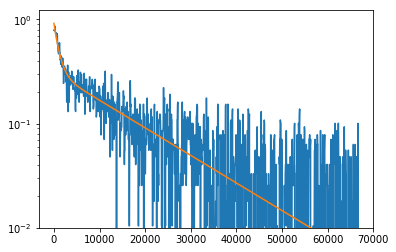

In [98]:
target =normalize(df[0].values[60:])
xlist = np.arange(0,50*len(target),50)
popt_new,perr_new = curve_fit_new(decay2,xlist,target)
plt.plot(xlist,target)

plt.plot(xlist,target-popt_new[-1])
plt.plot(xlist,decay2(xlist,*popt_new)-popt_new[-1])
plt.yscale('log')
plt.ylim(1e-2)

In [15]:
perr_new

NameError: name 'perr_new' is not defined

In [12]:
perr_new

array([3.03928779e-02, 8.72678045e-03, 5.04792554e+01, 8.12014143e+02,
       2.83232772e-03])

In [21]:
np.mean(fast_list)

615.091156362792

In [27]:
np.random.shuffle(t1_G_std)

In [28]:
t1_G_std

array([63.18758, 70.52462, 48.80223, 84.13497, 70.35679, 81.72991,
       74.42368, 69.26422, 48.96266, 83.93289])